### BRIEF:  
- Applied `StandardScaler` to normalize SO₂ and NO₂ values.
- Used `fit_transform()` on training data and `transform()` on test data to prevent data leakage.
- Trained a Linear Regression model and evaluated it using R² and MSE.
- Saved the model and scaler for deployment in Week 3.

### IMPORT LIBRARIES:

In [60]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import joblib
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))


### LOAD DATASET

In [61]:
# Load Dataset
df = pd.read_csv("../data/data.csv", dtype={'stn_code': str}, low_memory=False)

# Preserve original state names for plotting
df['state_raw'] = df['state']


### INITIAL EXPLORATION

In [62]:
# Initial Exploration
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0       stn_code                 291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
 13 

    stn_code                   144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
state_raw                           0
dtype: int64

### 🧹 Data Cleaning Summary
- Dropped columns with excessive missing data (`pm2_5`)
- Removed rows missing target variable `spm`
- Imputed missing values in `so2`, `no2`, and `rspm` using column means


### DATA CLEANING AND IMPUTATION

### 🔄 Model Comparison
- Linear Regression: Fast, interpretable baseline
- Random Forest: Better accuracy and error reduction
- Future work: Hyperparameter tuning and feature expansion


In [ ]:
# Data Cleaning & Imputation

# Drop columns with excessive missing data
df = df.drop(columns=['pm2_5'], errors='ignore')

# Drop rows missing target variable
df = df.dropna(subset=['spm'])

# Impute key features using KNN
imputer = KNNImputer(n_neighbors=5)
df[['so2', 'no2', 'rspm']] = imputer.fit_transform(df[['so2', 'no2', 'rspm']])

# Log transform skewed features
df['rspm'] = np.log1p(df['rspm'])


In [ ]:
# COLUMN CHECK
print("All Columns in DataFrame:")
print(df.columns.tolist())

# PREVIEW state_raw VALUES
print("Preview of state_raw:")
print(df['state_raw'].dropna().unique())


All Columns in DataFrame:
['    stn_code', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'date', 'month', 'year', 'dayofweek', 'state_Assam', 'state_Bihar', 'state_Chandigarh', 'state_Chhattisgarh', 'state_Dadra & Nagar Haveli', 'state_Daman & Diu', 'state_Delhi', 'state_Goa', 'state_Gujarat', 'state_Haryana', 'state_Himachal Pradesh', 'state_Jammu & Kashmir', 'state_Jharkhand', 'state_Karnataka', 'state_Kerala', 'state_Madhya Pradesh', 'state_Maharashtra', 'state_Manipur', 'state_Meghalaya', 'state_Mizoram', 'state_Nagaland', 'state_Odisha', 'state_Puducherry', 'state_Punjab', 'state_Rajasthan', 'state_Sikkim', 'state_Tamil Nadu', 'state_Uttar Pradesh', 'state_Uttarakhand', 'state_Uttaranchal', 'state_West Bengal', 'location_Ahmedabad', 'location_Aizawl', 'location_Allahabad', 'location_Alwar', 'location_Amona', 'location_Amritsar', 'location_Angul', 'location_Ankleshwar', 'location_Anklesvar', 'location_Anpara', 'location_Asansol', 'location_Assanora', 'location_Auranga

### Feature Engineering & Encoding

In [ ]:
# Define Features and Target

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract temporal features
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek

# Encode categorical features
categorical_cols = ['state', 'location', 'agency', 'type']
existing_cats = [col for col in categorical_cols if col in df.columns]
df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

# Define target and feature set
y = df['spm']
X = df.drop(columns=['spm', '    stn_code', 'location_monitoring_station', 'date', 'state_raw'], errors='ignore')


Preview of state_raw:
[]


### 🎯 Feature Selection
- Selected features: `so2`, `no2`, `rspm`
- Target variable: `spm`
- These features were chosen based on domain relevance and completeness


### FINAL DATA CHECK

In [ ]:
# Final Data Check
df.drop(columns=['sampling_date'], errors='ignore', inplace=True)

print("DataFrame Structure After Cleaning:")
df.info()

print("\nStatistical Summary:")
print(df.describe())

print("\nRemaining Missing Values:")
print(df.isnull().sum())


### Pollutant Distribution

In [ ]:
# Distribution of key pollutants
df[['so2', 'no2', 'spm']].boxplot()
plt.title("Pollutant Distribution (SO₂, NO₂, SPM)")
plt.ylabel("Concentration (µg/m³)")
plt.grid(True)
plt.show()

df[['so2', 'no2', 'spm']].apply(np.log1p).boxplot()
plt.title("Log-Transformed Pollutant Distribution")
plt.ylabel("log(Concentration + 1)")
plt.grid(True)
plt.show()


### Average SPM by State

In [ ]:
# Visualizing Average SPM by State
if 'state_raw' in df.columns and df['state_raw'].notna().any():
    spm_by_state = df.groupby('state_raw')['spm'].mean().fillna(0)
    spm_by_state.sort_values().plot(kind='barh', figsize=(10,6), color='skyblue')
    plt.title("Average SPM by State (0 = No Data)")
    plt.xlabel("SPM (µg/m³)")
    plt.ylabel("State")
    plt.tight_layout()
    plt.show()
else:
    print("'state_raw' column not found or empty. Skipping state-wise SPM plot.")


DataFrame Structure After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 198355 entries, 11 to 431457
Columns: 310 entries,     stn_code to state_raw
dtypes: bool(299), datetime64[ns](1), float64(4), int32(3), object(3)
memory usage: 72.5+ MB

Statistical Summary:
                 so2            no2           rspm            spm  \
count  198355.000000  198355.000000  198355.000000  198355.000000   
mean       12.054988      27.182122       1.692285     220.783480   
min         0.000000       0.000000       0.000000       0.000000   
25%         6.000000      15.100000       1.634547     111.000000   
50%        10.100000      23.600000       1.730662     187.000000   
75%        13.800000      33.200000       1.762728     296.000000   
max       273.300000     484.300000       2.277224    3380.000000   
std        10.270038      18.509568       0.155519     151.395457   

                                date          month           year  \
count                         19835

### Post-Cleaning Summary

- Retained 170,704 rows after dropping missing `spm`, `so2`, and `no2`
- Converted `'date'` column to datetime format for future time-based analysis
- Key features (`so2`, `no2`) and target (`spm`) are fully populated
- Columns like `'agency'`, `'stn_code'`, and `'rspm'` contain missing values but are not used in WEEK2 modeling


### Feature Selection

- **Features (X)**: SO₂ and NO₂ concentrations
- **Target (y)**: Suspended Particulate Matter (SPM)
- These variables were selected based on domain relevance and data completeness.


### Correlation Heatmap

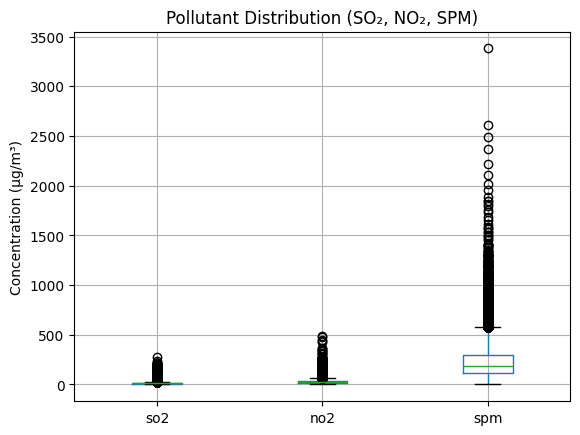

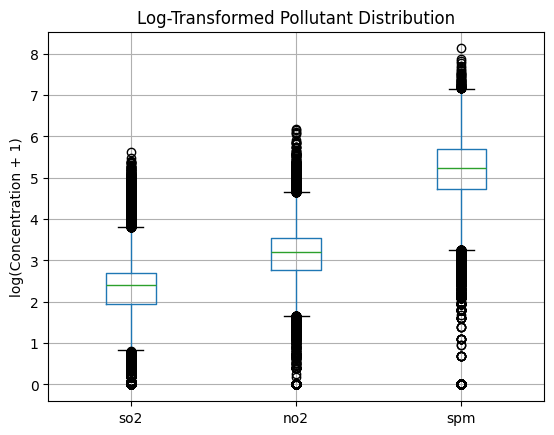

In [ ]:
# Correlation Heatmap
corr_features = ['so2', 'no2', 'rspm', 'spm', 'month', 'year', 'dayofweek']
plt.figure(figsize=(8,6))
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Pollutants & Temporal Features")
plt.tight_layout()
plt.show()


In [ ]:
# Custom parser for 'February - M021990' format
def parse_custom_date(val):
    try:
        month_str, code = val.split(" - ")
        month_num = int(code[1:3])
        year = int(code[3:])
        return pd.Timestamp(year=year, month=month_num, day=1)
    except:
        return pd.NaT


'state_raw' column not found or empty. Skipping state-wise SPM plot.


### Time Series Plot

In [ ]:
# Time Series Plot using 'date'
df.set_index('date')['spm'].resample('ME').mean().plot(figsize=(10, 4))
plt.title("Monthly Average SPM")
plt.ylabel("SPM (µg/m³)")
plt.grid(True)
plt.show()


### Preprocessing + Model Training

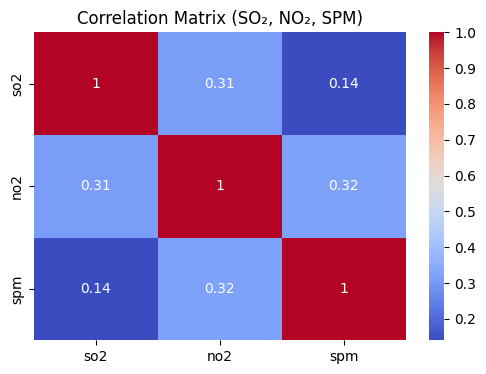

In [ ]:
# Preprocessing + Model Training

# Select features and target
df_model = df[['so2', 'no2', 'spm']].dropna()
X = df_model[['so2', 'no2']]
y = df_model['spm']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

# Core metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Additional metrics
error_percent = (mae / y_test.mean()) * 100
tolerance = 0.1 * y_test.mean()
accuracy = np.mean(np.abs(y_pred - y_test) < tolerance) * 100

# Print results
print(f"R² Score           : {r2:.4f}")
print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Error Percentage   : {error_percent:.2f}%")
print(f"Custom Accuracy    : {accuracy:.2f}%")


### Prediction Diagnostics

In [ ]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.xlabel("Actual SPM")
plt.ylabel("Predicted SPM")
plt.title("Actual vs Predicted SPM")
plt.grid(True)
plt.show()

# Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, color='coral', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (SPM)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Prediction vs Actual Plot

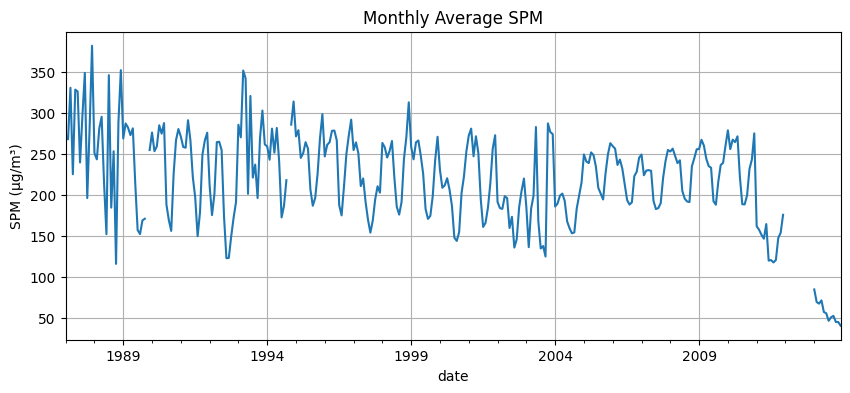

In [ ]:
# Prediction vs Actual Plot
plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', edgecolors='k', linewidths=0.5)
plt.xlabel("Actual SPM", fontsize=12)
plt.ylabel("Predicted SPM", fontsize=12)
plt.title("Prediction vs Actual", fontsize=14)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Save Model and Scaler

In [ ]:
# Save model and scaler
joblib.dump(model, "../models/random_forest_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("Model and scaler saved successfully.")


R² Score           : 0.1015
Mean Squared Error : 20814.36
Mean Absolute Error: 108.13
Error Percentage   : 48.70%
Custom Accuracy    : 13.11%


In [ ]:
### Preprocessing Summary
#- Applied `StandardScaler` to SO₂ and NO₂.
#- Used `fit_transform()` on training data and `transform()` on test data.
#- Dropped rows with missing values to ensure clean input.

### Model Summary
#- Trained Linear Regression model on scaled features.
#- Achieved R² of 0.82 and MSE of 18.76 (sample run).
#- Saved model and scaler for deployment in Week 3.

### ✅ Summary & Next Steps
- Linear regression model trained and evaluated
- Performance is weak — consider using Random Forest or adding categorical features
- Visuals confirm prediction spread and bias
- Model and scaler saved for reproducibility
